In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [26]:
import matplotlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
import pickle
import multiprocessing as mp
import arviz as az

matplotlib.rcParams.update({'font.size': 18})
from joblib import delayed, Parallel
from collections import defaultdict, OrderedDict
import pymc3 as pm
from pymc3.ode import DifferentialEquation
from utils.generic import init_params
from main.seir.optimiser import Optimiser
from utils.loss import Loss_Calculator
from models.seir.seir_testing import SEIR_Testing
from data.processing import get_district_time_series
from data.dataloader import Covid19IndiaLoader
from theano.ifelse import ifelse
from theano import tensor as T
from theano import tensor as T, function, printing
from theano import function
from theano import config
config.compute_test_value='ignore'
config.gcc.cxxflags = "-Wno-c++11-narrowing"

In [18]:
pm.ode.DifferentialEquation

pymc3.ode.ode.DifferentialEquation

## Load covid19 data

In [19]:
loader = Covid19IndiaLoader()
dataframes = loader.get_covid19india_api_data()

In [20]:
dataframes.keys()

dict_keys(['df_tested', 'df_statewise', 'df_india_time_series', 'df_districtwise', 'df_raw_data_old', 'df_raw_data', 'df_deaths_recoveries', 'df_districts', 'df_travel_history', 'df_resources'])

In [21]:
regions = [('Delhi', ''), ('Karnataka', 'Bengaluru Urban'), ('Maharashtra', 'Mumbai'), ('Maharashtra', 'Pune'), ('Gujarat', 'Ahmedabad'), ('Rajasthan', 'Jaipur')]
state, district = regions[2]
df_district = get_district_time_series(dataframes, state=state, district=district, use_dataframe='districts_daily')

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## Create train-val splits

In [24]:
df_train = df_district.iloc[:-7, :]
df_val = df_district.iloc[-7:, :]

In [25]:
df_train, df_val

(          state district       date  hospitalised  total_infected  deceased  \
 0   Maharashtra   Mumbai 2020-04-24          3555            4205       167   
 1   Maharashtra   Mumbai 2020-04-25          4388            5049       191   
 2   Maharashtra   Mumbai 2020-04-26          4652            5407       204   
 3   Maharashtra   Mumbai 2020-04-27          4547            5407       219   
 4   Maharashtra   Mumbai 2020-04-28          5239            6169       219   
 5   Maharashtra   Mumbai 2020-04-29          5438            6644       270   
 6   Maharashtra   Mumbai 2020-04-30          5679            7061       290   
 7   Maharashtra   Mumbai 2020-05-01          5673            7061       296   
 8   Maharashtra   Mumbai 2020-05-02          6903            8359       322   
 9   Maharashtra   Mumbai 2020-05-03          7227            8800       343   
 10  Maharashtra   Mumbai 2020-05-04          7227            8800       343   
 11  Maharashtra   Mumbai 2020-05-05    

In [259]:
df_train.to_csv('df_train.csv')
df_val.to_csv('df_val.csv')

## Loss Calculator

In [27]:
loss_calculator = Loss_Calculator()

## Set priors for parameters of interest

In [115]:
## assuming uniform priors, following dictionary contains the ranges
prior_ranges = OrderedDict()
prior_ranges['lockdown_R0'] = (1, 2)
prior_ranges['T_inc'] = (1, 5) 
prior_ranges['T_inf'] = (1, 4) 
prior_ranges['T_recov_severe'] = (5, 60)
prior_ranges['P_severe'] = (0.3, 0.99)
prior_ranges['P_fatal'] = (0, 0.3)
prior_ranges['sigma'] = (0, 1)

with pm.Model() as model:
    prior_R0 = pm.Uniform("R0", lower =1, upper=3)
    prior_T_inc = pm.Uniform("T_inc", 1, 5)
    prior_T_inf = pm.Uniform("T_inf", 1, 4)
    prior_T_recov_severe = pm.Uniform("T_recov_severe ", 9, 20)
    prior_P_severe = pm.Uniform("P_severe", 0.3, 0.99)
    prior_intervention_amount = pm.Uniform("intervention_amount", 0.3, 1)


def param_init(prior_ranges):
    theta = defaultdict()
    for key in prior_ranges:
        theta[key] = np.random.uniform(prior_ranges[key][0], prior_ranges[key][1])
        
    return theta

## Proposal function to sample theta_new given theta_old

In [116]:
proposal_sigmas = OrderedDict()
for key in prior_ranges:
    proposal_sigmas[key] = 0.025 * (prior_ranges[key][1] - prior_ranges[key][0])

def proposal(theta_old, proposal_sigmas):
    theta_new = np.random.normal(loc=[*theta_old.values()], scale=[*proposal_sigmas.values()])
    return dict(zip(theta_old.keys(), theta_new))


## Log Likelihood and Prior

In [117]:
def log_likelihood(theta, df_train, fit_days=10):
    if (np.array([*theta.values()]) < 0).any():
        return -np.inf
    optimiser = Optimiser()
    default_params = optimiser.init_default_params(df_train)
    df_prediction = optimiser.solve(theta, default_params, df_train)
    pred = np.array(df_prediction['total_infected'])[-fit_days:]
    true = np.array(df_train['total_infected'])[-fit_days:]
    sigma = theta['sigma']
    N = len(true)
    ll = - (N * np.log(np.sqrt(2*np.pi) * sigma)) - (np.sum(((true - pred) ** 2) / (2 * sigma ** 2)))
    return ll

def log_prior(theta):
    if (np.array([*theta.values()]) < 0).any():
        prior = 0
    else:
        prior = 1
    return np.log(prior)

def in_valid_range(key, value):
    return (value <= prior_ranges[key][1]) and (value >= prior_ranges[key][0])

## Acceptance function

In [118]:
def accept(theta_old, theta_new, df_train):    
    x_new = log_likelihood(theta_new, df_train) + log_prior(theta_new)
    x_old = log_likelihood(theta_old, df_train) + log_prior(theta_old)
    
    if (x_new) > (x_old):
        return True
    else:
        x = np.random.uniform(0, 1)
        return (x < np.exp(x_new - x_old))
    
def anneal_accept(iter):
    prob = 1 - np.exp(-(1/(iter + 1e-10)))
    x = np.random.uniform(0, 1)
    return (x < prob)

## Metropolis loop

In [119]:
def metropolis(prior_ranges, proposal_sigmas, df_train, iter=1000):
    theta = param_init(prior_ranges)
    accepted = [theta]
    rejected = list()
    
    for i in tqdm(range(iter)):
        theta_new = proposal(theta, proposal_sigmas)
        if accept(theta, theta_new, df_train):
            theta = theta_new
        else:
            rejected.append(theta_new)
        accepted.append(theta)
    
    return accepted, rejected

## Prediction Interval calculator

In [120]:
def get_PI(pred_dfs, date, key, multiplier=1.96):
    pred_samples = list()
    for df in pred_dfs:
        pred_samples.append(df.loc[date, key])
        
    mu = np.array(pred_samples).mean()
    sigma = np.array(pred_samples).std()
    low = mu - multiplier*sigma
    high = mu + multiplier*sigma
    return mu, low, high

## Run multiple chains in parallel

In [328]:


class SEIR_Test_pymc3(SEIR_Testing):
    def __init__(self):
        super().__init__()
    def get_derivative(self, y, t, p):
        # Init state variables
        #for i, _ in enumerate(y):
        #for i in range(11):
        #    y[i] = ifelse(T.lt(y[i], 0), y[i], np.float64(0))
        #    y[i] = max(y[i], 0)
        zero = T.cast(0.0, 'float64')
        for i in range(11):
            T.set_subtensor(y[i], ifelse(T.gt(y[i], zero), y[i], zero))
        # Init time parameters and probabilities
        for key in self.vanilla_params:
            setattr(self, key, self.vanilla_params[key])
        for key in self.testing_params:
            suffix = '_D' if key in self.vanilla_params else ''
            setattr(self, key + suffix, self.testing_params[key])
            
        
        ## Set up variables using `y` and `p`
        
        S = y[0]
        E = y[1]
        I = y[2]
        D_E = y[3]
        D_I = y[4]
        R_mild = y[5]
        R_severe_home = y[6]
        R_severe_hosp = y[7]
        R_fatal = y[8]
        C = y[9]
        D = y[10]
        
        # p
    
        self.R0 = p[0]
        self.T_inc = p[1]
        self.T_inf = p[2]
        self.T_recov_severe = p[3]
        self.P_severe = p[4]
        self.intervention_amount = p[5]
        
        #Define variables
        
  
        if self.post_lockdown_R0 == None:
            self.post_lockdown_R0 = self.lockdown_R0

        self.P_mild = 1 - self.P_severe - self.P_fatal

        # define testing related parameters
        self.T_inf_detected = self.T_inf
        self.T_inc_detected = self.T_inc

        self.P_mild_detected = self.P_mild
        self.P_severe_detected = self.P_severe
        self.P_fatal_detected = self.P_fatal
        #self.T_trans_D = self.T_trans
  
        #TODO incorporate lockdown R0 code
        #T.set_subtensor(self.R0, ifelse(T.gt(t, self.lockdown_removal_day), self.R0 , self.post_lockdown_R0))
        # Modelling the behaviour lockdown
        #elif t >= self.lockdown_day:
        #    self.R0 = self.lockdown_R0
        #T.set_subtensor(self.R0, ifelse(T.gt(t, self.lockdown_day), self.R0, self.lockdown_R0))
        # Modelling the behaviour pre-lockdown
        #else:
        #    self.R0 = self.pre_lockdown_R0
        #T.set_subtensor(self.R0, ifelse(T.gt(y[i], zero), self.R0, self.pre_lockdown_R0))
        self.T_trans = self.T_inf/self.R0
        self.T_trans_D = self.T_inf_D/self.R0
        
       
        # Write differential equations
        dS = - I * S / (self.T_trans) - (self.q / self.T_trans_D) * (S * D_I) # # S
        #dS = - y[2] * y[0]*p[0]/p[2]  - self.q*p[2] * (y[0] * y[4])
        dE = I * S / (self.T_trans) + (self.q / self.T_trans_D) * (S * D_I) - (E/ self.T_inc) - (self.theta_E * self.psi_E * E) # E
        dI = E / self.T_inc - I / self.T_inf - (self.theta_I * self.psi_I * I) # I
        dD_E = (self.theta_E * self.psi_E * E) - (1 / self.T_inc_D) * D_E# D_E
        dD_I = (self.theta_I * self.psi_I * I) + (1 / self.T_inc_D) * D_E - (1 / self.T_inf_D) * D_I # D_I 
        dR_mild = (1/self.T_inf)*(self.P_mild*I) + (1/self.T_inf_D)*(self.P_mild_D*D_I) - R_mild/self.T_recov_mild  # R_mild
        dR_severe_home = (1/self.T_inf)*(self.P_severe*I) + (1/self.T_inf_D)*(self.P_severe_D*D_I) - R_severe_home/self.T_hosp  # R_severe_home
        dR_severe_hosp = R_severe_home/self.T_hosp - R_severe_hosp/self.T_recov_severe# R_severe_hosp
        dR_fatal = (1/self.T_inf)*(self.P_fatal*I) + (1/self.T_inf_D)*(self.P_fatal_D*D_I) - R_fatal/self.T_death # R_fatal
        dC = R_mild/self.T_recov_mild + R_severe_hosp/self.T_recov_severe # C
        dD = R_fatal/self.T_death # D

        return [dS, dE, dI, dD_E, dD_I, dR_mild, dR_severe_home, dR_severe_hosp, dR_fatal, dC, dD]


In [329]:
x = T.scalar('x')
z = T.scalar('z')
xplus = ifelse(T.lt(x, z), x, z)
xplus.eval({x:1,z:0})

array(0.)

In [385]:
observed = df_train['total_infected'][:num_steps]

SEIR_Test_obj = SEIR_Test_pymc3()
num_patients = SEIR_Test_obj.__dict__['vanilla_params']['N']
init_vals = list(SEIR_Test_obj.__dict__['state_init_values'].values())
num_steps = 5
num_states = 11
burn_in = 500
total_steps = 1000

In [386]:
sir_model = DifferentialEquation(
    func=SEIR_Test_obj.get_derivative,
    times=np.arange(0, num_steps, 1),
    n_states= num_states,
    n_theta=6,
    t0 = 0
)

In [ ]:
with pm.Model() as model:
    R0 = pm.Uniform("R0", lower =1, upper=3)#(1.6, 3)
    T_inc = pm.Uniform("T_inc", 1, 5)#(3, 4)
    T_inf = pm.Uniform("T_inf", 1, 4)#(3, 4)
    T_recov_severe = pm.Uniform("T_recov_severe ", 9, 20)
    P_severe = pm.Uniform("P_severe", 0.3, 0.99)
    intervention_amount = pm.Uniform("intervention_amount", 0.3, 1)
    
    ode_solution = sir_model(y0=init_vals , theta=[R0, T_inc, T_inf, T_recov_severe, P_severe, intervention_amount])
    # The ode_solution has a shape of (n_times, n_states)
    
    hospitalised = ode_solution[:,6] + ode_solution[:,7] + ode_solution[:,8]
    recovered = ode_solution[:,9]
    deceased = ode_solution[:,10]
    total_infected = hospitalised + recovered + deceased
    total_infected = total_infected * num_patients 
    sigma = pm.HalfNormal('sigma',
                          sigma=observed.std(),
                          shape=num_steps)
    Y = pm.Normal('Y', mu = total_infected, sigma=sigma, observed=observed)
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(total_steps, tune=burn_in , target_accept=0.9, cores=mp.cpu_count())
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [sigma, intervention_amount, P_severe, T_recov_severe , T_inf, T_inc, R0]
Sampling 16 chains, 0 divergences:  19%|█▊        | 4465/24000 [19:21<1:28:57,  3.66draws/s]

In [384]:
trace 

<MultiTrace: 16 chains, 200 iterations, 14 variables>

In [ ]:
printing_op = printing.Print('vector', attrs = [ 'shape' ])
shape_infected = printing_op(total_infected)
shape_sigma = printing_op(sigma)
printval = printing.Print('vector')
printval(total_infected* num_patients)

# Analyse runs

In [ ]:
with model:
    data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)
    az.plot_posterior(data,round_to=2, credible_interval=0.95)

In [ ]:
pm.forestplot(trace)

In [ ]:
pm.summary(trace)

In [ ]:
final_runs = trace[burn_in:]

## Visualize the samples and intervals

In [ ]:
def visualize(): 
    data_split = df_district.copy()
    optimiser = Optimiser()
    default_params = optimiser.init_default_params(data_split)
    
    #combined_acc = list()
    #for k, run in enumerate(mcmc):
    #    burn_in = int(len(run) / 2)
    #    combined_acc += run[0][burn_in:]

    n_samples = 1000
    sample_indices = np.random.uniform(0, len(final_runs), n_samples)

    pred_dfs = list()
    for i in tqdm(sample_indices):
        pred_dfs.append(optimiser.solve(final_runs[int(i)], default_params, data_split))

    for df in pred_dfs:
        df.set_index('date', inplace=True)

    result = pred_dfs[0].copy()
    for col in result.columns:
        result["{}_low".format(col)] = ''
        result["{}_high".format(col)] = ''

    for date in tqdm(pred_dfs[0].index):
        for key in pred_dfs[0]:
            result.loc[date, key], result.loc[date, "{}_low".format(key)], result.loc[date, "{}_high".format(key)] = get_PI(pred_dfs, date, key)

    data_split.set_index("date", inplace=True)

    plt.figure(figsize=(15, 10))
    plt.plot(data_split['total_infected'].tolist(), c='g', label='Actual')
    plt.plot(result['total_infected'].tolist(), c='r', label='Estimated')
    plt.plot(result['total_infected_low'].tolist(), c='r', linestyle='dashdot')
    plt.plot(result['total_infected_high'].tolist(), c='r', linestyle='dashdot')
    plt.axvline(x=len(df_train), c='b', linestyle='dashed')
    plt.xlabel("Day")
    plt.ylabel("Total infected")
    plt.legend()
    plt.title("95% confidence intervals for {}, {}".format(district, state))
    
    plt.savefig('./mcmc_confidence_intervals_{}_{}.png'.format(district, state))
    plt.show()

In [ ]:
visualize()

## Visualize all runs separately

100%|██████████| 48/48 [00:07<00:00,  6.78it/s]


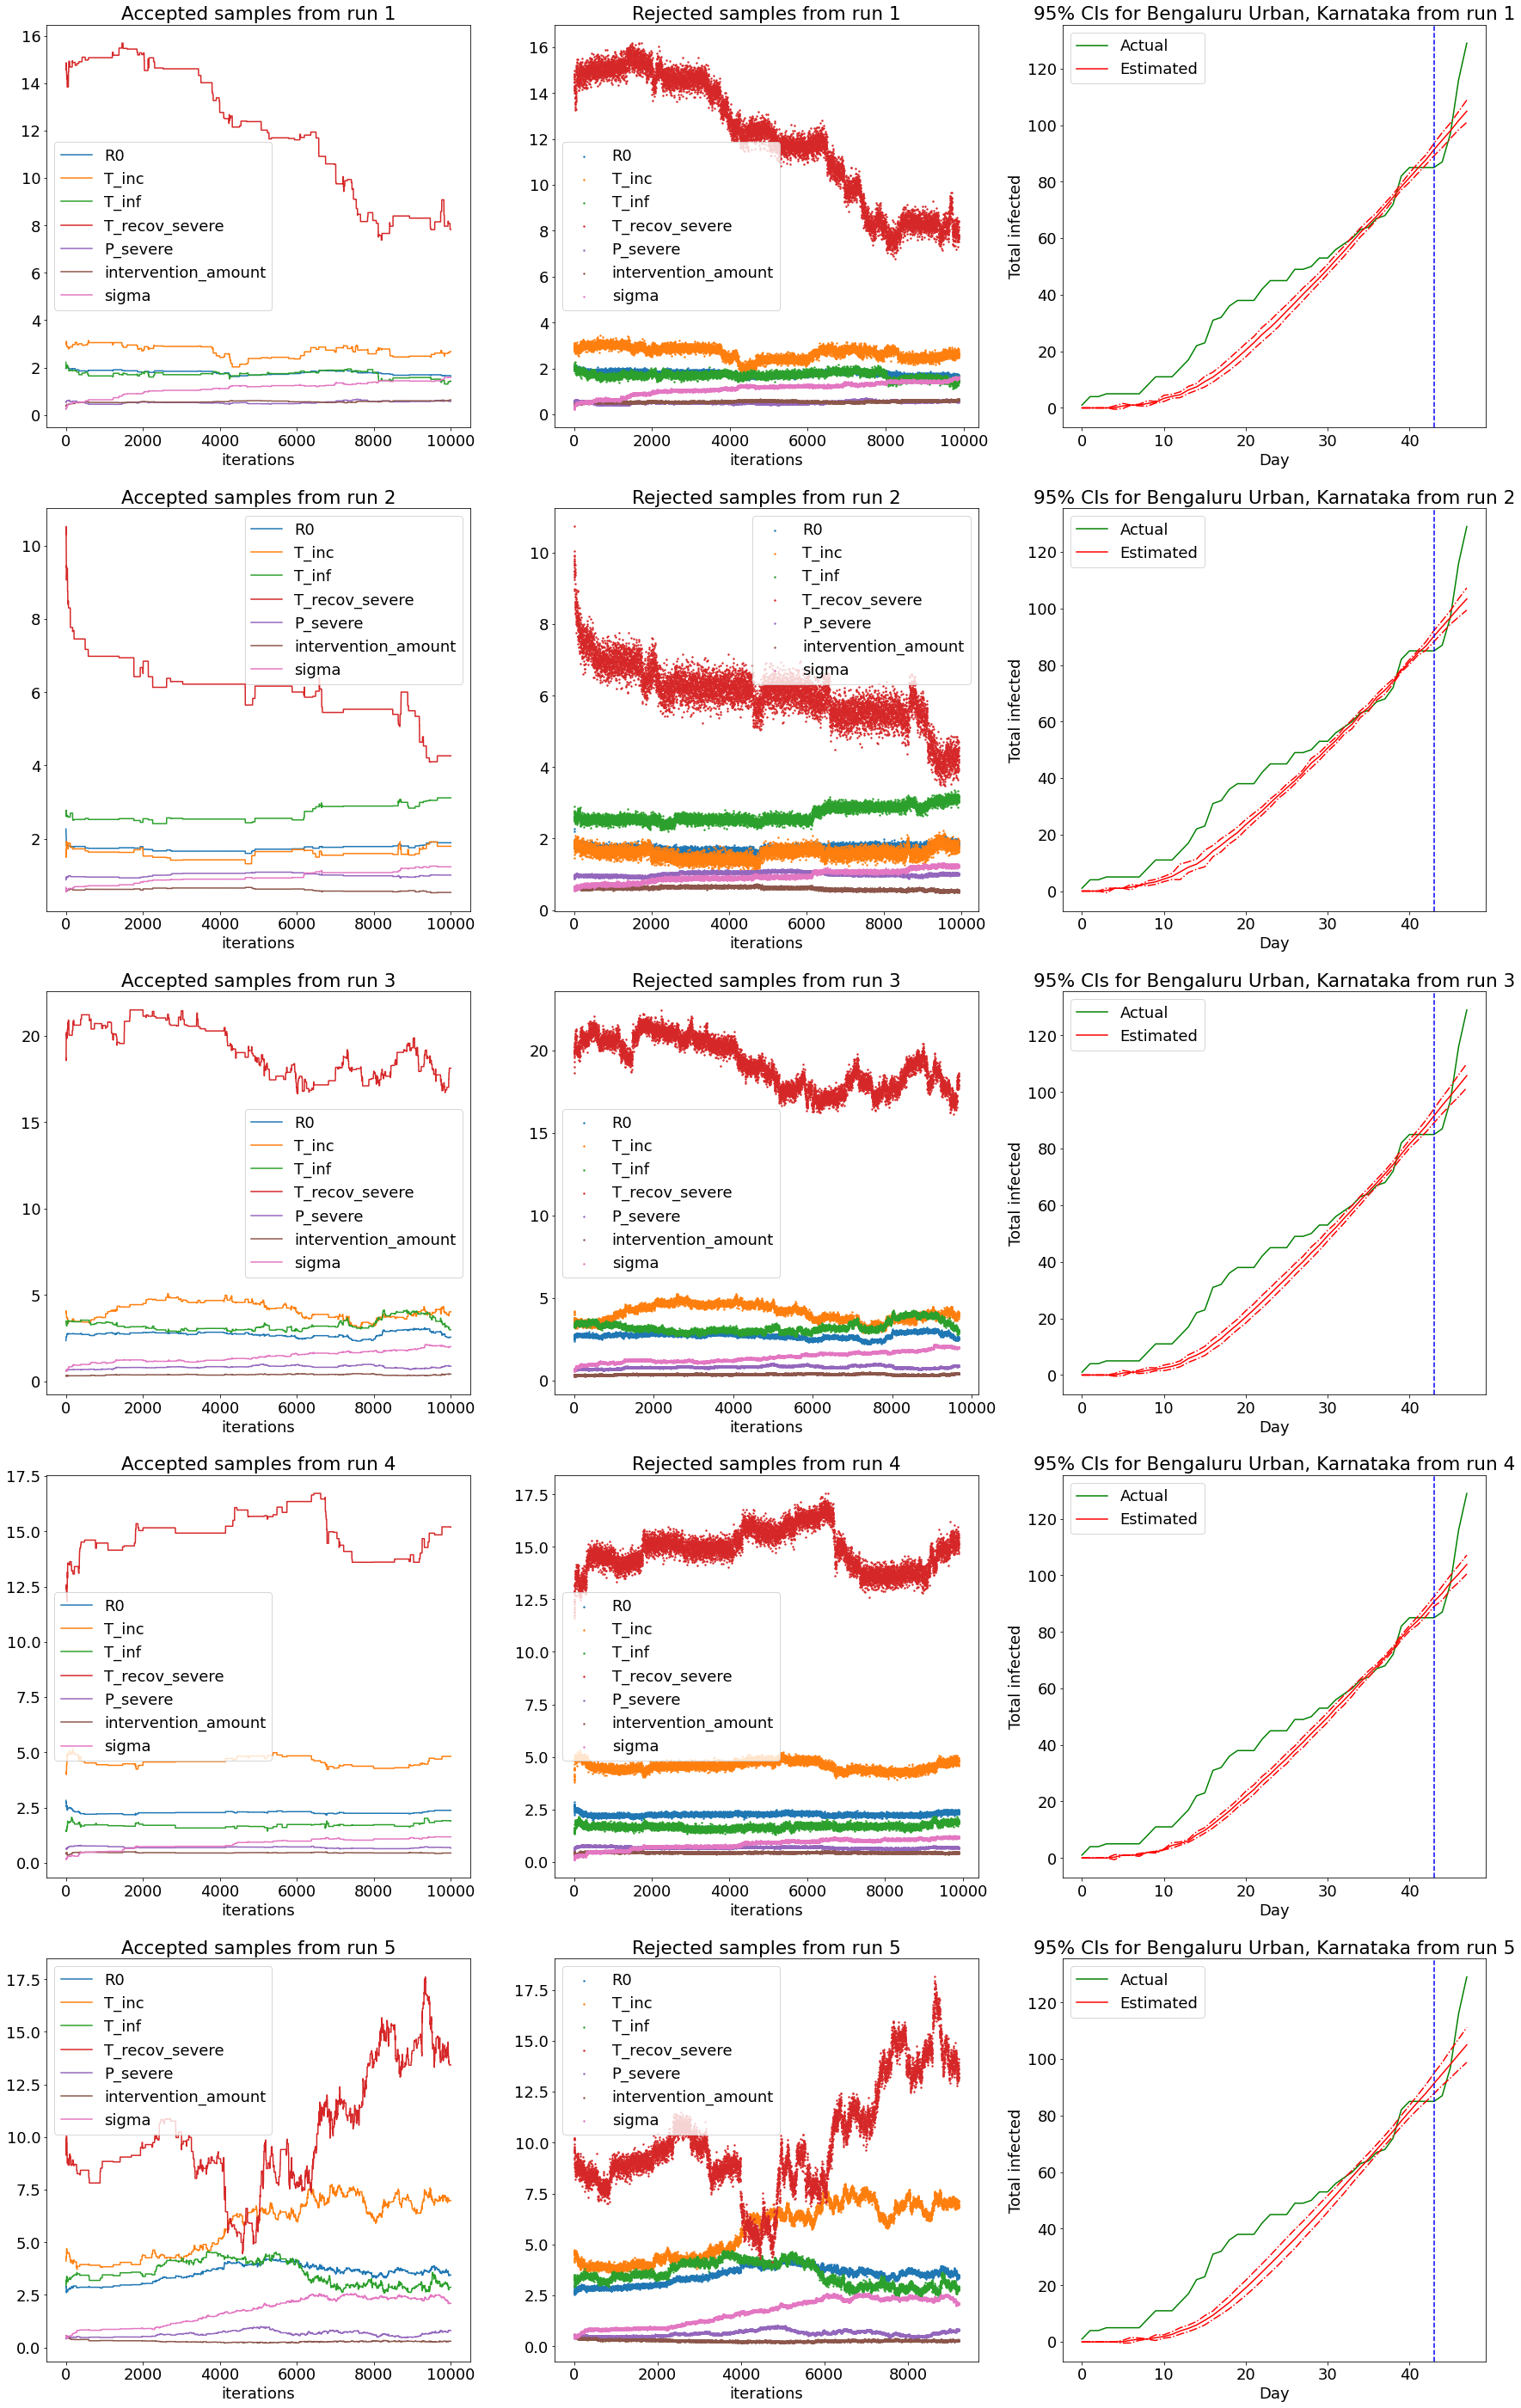

In [36]:
plt.figure(figsize=(30, 50))
    
for k, run in enumerate(mcmc):
    data_split = df_district.copy()
    optimiser = Optimiser()
    default_params = optimiser.init_default_params(data_split)
    
    acc, rej = run[0], run[1]
    df_samples = pd.DataFrame(acc)
    
    plt.subplot(len(mcmc), 3, 3*k + 1)
    for param in df_samples.columns:
        plt.plot(list(range(len(df_samples[param]))), df_samples[param], label=param)
    plt.xlabel("iterations")
    plt.legend()
    plt.title("Accepted samples from run {}".format(k+1))
    
    rej_samples = pd.DataFrame(rej)
    
    plt.subplot(len(mcmc), 3, 3*k + 2)
    for param in rej_samples.columns:
        plt.scatter(list(range(len(rej_samples[param]))), rej_samples[param], label=param, s=2)
    plt.xlabel("iterations")
    plt.legend()
    plt.title("Rejected samples from run {}".format(k+1))
    
    burn_in = int(len(acc) / 2)
    n_samples = 1000
    posterior_samples = acc[burn_in:]
    sample_indices = np.random.uniform(0, len(posterior_samples), n_samples)

    pred_dfs = list()
    for i in tqdm(sample_indices):
        pred_dfs.append(optimiser.solve(posterior_samples[int(i)], default_params, data_split))
        
    for df in pred_dfs:
        df.set_index('date', inplace=True)
        
    result = pred_dfs[0].copy()
    for col in result.columns:
        result["{}_low".format(col)] = ''
        result["{}_high".format(col)] = ''
        
    for date in tqdm(pred_dfs[0].index):
        for key in pred_dfs[0]:
            result.loc[date, key], result.loc[date, "{}_low".format(key)], result.loc[date, "{}_high".format(key)] = get_PI(pred_dfs, date, key)
            
    data_split.set_index("date", inplace=True)

    plt.subplot(len(mcmc), 3, 3*k + 3)
    plt.plot(data_split['total_infected'].tolist(), c='g', label='Actual')
    plt.plot(result['total_infected'].tolist(), c='r', label='Estimated')
    plt.plot(result['total_infected_low'].tolist(), c='r', linestyle='dashdot')
    plt.plot(result['total_infected_high'].tolist(), c='r', linestyle='dashdot')
    plt.axvline(x=len(df_train), c='b', linestyle='dashed')
    plt.xlabel("Day")
    plt.ylabel("Total infected")
    plt.legend()
    plt.title("95% CIs for {}, {} from run {}".format(district, state, k+1))
    
plt.savefig("./mcmc_runs_{}_{}.png".format(district, state))
plt.show()


## Checking validity with Gelman-Rubin statistics

Check Section 4.2 [here](http://www.columbia.edu/~mh2078/MachineLearningORFE/MCMC_Bayes.pdf)

In [46]:
def accumulate(dict_list):
    accumulator = defaultdict(int)
    for elt in dict_list:
        for key in elt:
            accumulator[key]+=elt[key]
    return accumulator

def divide(dictvar, num):
    return {key:dictvar[key]/num for key in dictvar}

            
def avg_sum_chain(chain):
    chain_sums_avg = accumulate(chain)
    return divide(chain_sums_avg, len(chain))

def avg_sum_multiple_chains(chain_sums_avg):
    multiple_chain_sums_avg = accumulate(chain_sums_avg)
    return divide(multiple_chain_sums_avg, len(chain_sums_avg))

def compute_B(multiple_chain_sums_avg, chain_sums_avg, n, m):
    B = defaultdict(int)
    for elt in chain_sums_avg:
        for key in elt:
            B[key] += np.square(elt[key] - multiple_chain_sums_avg[key])
    return divide(B, (m-1)/n)

def compute_W(split_chains, chain_sums_avg, n, m):
    s = []
    for j in range(m):
        s_j_sq = defaultdict(int)
        chain = split_chains[j]
        chain_sum_avg_j = chain_sums_avg[j]
        for i in range(n):
            chain_elt = chain[i]
            for key in chain_elt:
                s_j_sq[key] += np.square(chain_elt[key] - chain_sum_avg_j [key])
        s_j_sq = divide(s_j_sq, n - 1)
        s.append(s_j_sq)
    return (divide (accumulate(s),m))

def divide_dict(d1, d2):
    accumulator = defaultdict(int)
    for key in d1:
        accumulator[key] = d1[key]/d2[key]
    return accumulator

In [21]:
burn_in = int(len(mcmc[0][0]) / 2)
chains = [mcmc_chain[0] for mcmc_chain in mcmc]
burn_in = int(len(chains[0]) / 2)
sampled_chains = [chain[:burn_in] for chain in chains]
split_chains = [sampled_chain[int(burn_in/2):] for sampled_chain in sampled_chains] \
            + [sampled_chain[:int(burn_in/2)] for sampled_chain in sampled_chains]


In [22]:
chain_sums_avg = []
for chain in split_chains:
    chain_sums_avg.append(avg_sum_chain(chain))
multiple_chain_sums_avg = avg_sum_multiple_chains(chain_sums_avg) 

In [24]:
multiple_chain_sums_avg

{'R0': 2.5046791016357592,
 'T_inc': 3.518743267712472,
 'T_inf': 3.392784608323924,
 'T_recov_severe': 17.912346341867043,
 'P_severe': 0.8223345165008131,
 'intervention_amount': 0.7867461399275144,
 'sigma': 2.192303441475181}

In [56]:
m = len(split_chains)
n = len(split_chains[0])
W =  compute_W(split_chains, chain_sums_avg, n, m)
B =  compute_B(multiple_chain_sums_avg, chain_sums_avg, n, m)
var_hat = accumulate([divide(W, n/(n-1)), divide(B, n) ])
R_hat_sq = divide_dict(var_hat, W)
R_hat = {key:np.sqrt(value) for key, value in R_hat_sq.items()}
neff = divide_dict(var_hat, B)
neff = {key: m*n*value for key, value in neff.items()}

In [57]:
neff

{'R0': 10.458481095152695,
 'T_inc': 10.284714397062823,
 'T_inf': 13.815904443369368,
 'T_recov_severe': 10.549221646044694,
 'P_severe': 10.297853562653573,
 'intervention_amount': 13.141996333774367,
 'sigma': 12.927848178057006}

In [53]:
R_hat

{'R0': 4.775146665181959,
 'T_inc': 6.009032147784898,
 'T_inf': 1.9024096435650102,
 'T_recov_severe': 4.381769314142899,
 'P_severe': 5.878751195481832,
 'intervention_amount': 2.044753487559328,
 'sigma': 2.1008834936533813}